In [1]:
from argparse import ArgumentParser
import os
import sys
import time

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import shapely
import xarray as xr

# from matplotlib import colors
from pandarallel import pandarallel

from reaches import *
from utils import *

### Parse arguments

In [2]:
# FOR NOW, SET
width_set = 'min'

# Control flow
if width_set == 'mean':
    width = 'WidthM'
    binn = 'Bin'
elif width_set == 'min':
    width = 'WidthM_Min'
    binn = 'Bin_Min'
elif width_set == 'max':
    width = 'WidthM_Max'
    binn = 'Bin_Max'
else:
    print('Invalid width option specified, exiting.')
    # sys.exit()

In [3]:
huc2 = '01' ### SET THIS
data_path = '/nas/cee-water/cjgleason/fiona/data/PIXC_v2_0_HUC2_' + huc2
# save_dir =

### Pixel Cloud

In [4]:
# Get job index
# slurm = int(os.environ['SLURM_ARRAY_TASK_ID'])
index = 106

In [5]:
huc2 = '01'
file_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/PIXC_v2_0_HUC2_' + huc2 + '_filtered.json'
data = open_json(file_path)

In [6]:
file_name = data[index]

In [7]:
# Get data for this tile
granule_name = file_name[:-3]
tile_name = file_name[20:28]
pass_num = int(file_name[20:23])

print(granule_name)

SWOT_L2_HR_PIXC_002_007_235R_20230811T080638_20230811T080649_PGC0_01


#### Read in PIXC

In [8]:
# Set PIXC filepath
pixc_path = os.path.join(data_path, file_name)

In [9]:
# Read in pixel group
ds_PIXC = xr.open_mfdataset(paths=pixc_path, group = 'pixel_cloud', engine='h5netcdf')

In [10]:
ds_PIXC

<xarray.Dataset> Size: 875MB
Dimensions:                                (points: 3168755, complex_depth: 2,
                                            num_pixc_lines: 3268)
Coordinates:
    latitude                               (points) float64 25MB dask.array<chunksize=(452680,), meta=np.ndarray>
    longitude                              (points) float64 25MB dask.array<chunksize=(452680,), meta=np.ndarray>
Dimensions without coordinates: points, complex_depth, num_pixc_lines
Data variables: (12/61)
    azimuth_index                          (points) float64 25MB dask.array<chunksize=(792189,), meta=np.ndarray>
    range_index                            (points) float64 25MB dask.array<chunksize=(792189,), meta=np.ndarray>
    interferogram                          (points, complex_depth) float32 25MB dask.array<chunksize=(1056252, 1), meta=np.ndarray>
    power_plus_y                           (points) float32 13MB dask.array<chunksize=(792189,), meta=np.ndarray>
    power_minus_y                          (points) float32 13MB dask.array<chunksize=(792189,), meta=np.ndarray>
    coherent_power                         (points) float32 13MB dask.array<chunksize=(792189,), meta=np.ndarray>
    ...                                     ...
    pixc_line_qual                         (num_pixc_lines) float64 26kB dask.array<chunksize=(3268,), meta=np.ndarray>
    pixc_line_to_tvp                       (num_pixc_lines) float32 13kB dask.array<chunksize=(3268,), meta=np.ndarray>
    data_window_first_valid                (num_pixc_lines) float64 26kB dask.array<chunksize=(3268,), meta=np.ndarray>
    data_window_last_valid                 (num_pixc_lines) float64 26kB dask.array<chunksize=(3268,), meta=np.ndarray>
    data_window_first_cross_track          (num_pixc_lines) float32 13kB dask.array<chunksize=(3268,), meta=np.ndarray>
    data_window_last_cross_track           (num_pixc_lines) float32 13kB dask.array<chunksize=(3268,), meta=np.ndarray>
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3268
    interferogram_size_range:    4726
    looks_to_efflooks:           1.5453628945818938
    num_azimuth_looks:           7.0
    azimuth_offset:              5

In [19]:
def bitwiseMask(ds):
    '''
    This function masks a PIXC granules: for now, it ony remove pixels
    with land classification and those with bad geolocation_qual.
    # See page 65 of PIXC PDD: https://podaac.jpl.nasa.gov/SWOT?tab=datasets-information&sections=about%2Bdata
    '''
    # Fow now, eliminate the really bad stuff
    mask = np.where((ds.classification > 1) & 
                    (ds.interferogram_qual < 2**7) & (ds.classification_qual < 2**7) &
                    (ds.geolocation_qual < 2**7) & (ds.sig0_qual < 2**7) &
                    (np.abs(ds.cross_track) > 10000) & (np.abs(ds.cross_track) < 60000))[0]
    
    print(mask.shape)
    return mask

In [20]:
# Make mask
mask = bitwiseMask(ds_PIXC)

if mask.shape[0] == 0:
    print('This granule has no pixels after masking, exiting.')
    # sys.exit(1)    

(742270,)


In [12]:
# Set desired data vars
variables = ['azimuth_index', 'range_index', 'cross_track',
             'pixel_area', 'height', 'geoid', 'prior_water_prob',
             'classification']

In [13]:
# Convert PIXC to GeoDataFrame
gdf_PIXC = makeGDF(ds=ds_PIXC, mask=mask, data_vars=variables)

### Find correct HUC4s

In [14]:
### NHDPlus HR
## Find correct HUC4s
# Read in tile and HUC4 intersection data
mdata_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/'
dtype_dic= {'tile': str, 'huc4': str, 'coverage': float}
tile_huc4 = pd.read_csv(os.path.join(mdata_path,
                                    'huc4_swot_science_tiles.csv'),
                        dtype=dtype_dic)

In [15]:
# Make list of HUC4s that intersect the tile
hucs = list(tile_huc4[(tile_huc4['tile'] == tile_name)]['huc4'])
# Limit to the current HUC2
hucs = [x for x in hucs if x.startswith(huc2)]

In [16]:
hucs

['0101', '0102', '0105']

In [17]:
# Get NHD index metadata
# Define dtypes for lookup tables to preserve leading zeros
dtype_dic= {'HUC4': str, 'HUC2': str, 'toBasin': str, 'level': str}
# Read in HUC lookup table
huc_lookup = pd.read_csv(os.path.join(mdata_path,
                                  'HUC4_lookup_no_great_lakes.csv'),
                     dtype=dtype_dic)

In [18]:
# Extract indices for read-in
indices = list(huc_lookup[huc_lookup['HUC4'].isin(hucs)]['slurm_index'])

### Read in HUC4 flowliness

In [19]:
# Create merged dataframe of all flowlines intersected
if len(indices) == 1:
    # Read prepped NHD
    flowlines, _, _,  = readNHD(index=indices[0])
    # huc4_list, huc2_list = readNHD(index=indices[0])
else:
    # Initialize lists
    d = []
    # huc4_list = []
    # huc2_list = []
    # Loop through indices and store in lists
    for i in indices:
        # Read prepped NHD
        flowlines, _, _ = readNHD(index=i)
        # huc4, huc2 = readNHD(index=i)
        # Append to lists
        d.append(flowlines)
        # huc4_list.append(huc4) # I DON'T DO ANYTHING WITH THIS
        # huc2_list.append(huc2) # I DON'T DO ANYTHING WITH THIS
    # Merge GeoDataFrames
    flowlines = pd.concat(d)

type: normal
NHDPLUS_H_0101_HU4_GDB
flowlines read-in
exploded
type: normal
NHDPLUS_H_0102_HU4_GDB
flowlines read-in
exploded
type: normal
NHDPLUS_H_0105_HU4_GDB
flowlines read-in
exploded


In [20]:
# Project CRS (currently to WGS 84 / UTM zone 18N) 
flowlines = flowlines.to_crs(epsg=3857)

In [21]:
pandarallel.initialize(nb_workers=int(os.environ.get('SLURM_CPUS_PER_TASK')))

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [22]:
start = time.time()
# Args are the width, cap_style, segmented=False, extra=False
# Buffering with extra distance to capture pixels that would overlap
# once converted to pseudo-pixels
flowlines['buffer'] = flowlines.parallel_apply(user_defined_function=specialBuffer,
                                                         args=(width,
                                                               'flat', False, True),
                                                         axis=1)
end = time.time()
print(end - start)

18.935839414596558


In [23]:
# Set geometry to buffered reaches
flowlines = flowlines.set_geometry('buffer').set_crs(epsg=3857)

In [24]:
flowlines.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [25]:
# Clip masked pixels to buffered reaches
gdf_PIXC_clip = gpd.sjoin(gdf_PIXC, flowlines, how='inner', predicate='within')

In [26]:
gdf_PIXC_clip.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
if gdf_PIXC_clip.shape[0] == 0:
    print('This granule has no pixels that intersect reaches, exiting.')
    # sys.exit() 

In [28]:
gdf_PIXC_clip.columns

Index(['points', 'azimuth_index', 'range_index', 'cross_track', 'pixel_area',
       'height', 'geoid', 'prior_water_prob', 'klass', 'latitude', 'longitude',
       'geometry', 'index_right', 'NHDPlusID', 'GNIS_Name', 'LengthKM',
       'WidthM', 'WidthM_Min', 'WidthM_Max', 'Bin', 'Bin_Min', 'Bin_Max',
       'StreamOrde', 'geometry_right'],
      dtype='object')

In [29]:
# Drop unneeded cols
gdf_PIXC_clip = gdf_PIXC_clip.drop(columns=['index_right', 'NHDPlusID',
                                            'GNIS_Name', 'LengthKM',
                                            'WidthM', 'WidthM_Min',
                                            'WidthM_Max', 'Bin', 'Bin_Min',
                                            'Bin_Max', 'geometry_right'])

In [30]:
### STOPPED HERE 02-25-25

### Nadir track

In [31]:
# Get single pixel for selecting correct nadir segment
pixel_pt = gdf_PIXC_clip.iloc[0].geometry

In [32]:
# Find correct nadir segment and return its geometry
nadir_segment_ln = findNadir(pass_num=pass_num, pixel_pt=pixel_pt)

/work/pi_cjgleason_umass_edu/.conda/envs/narrowPIXC/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


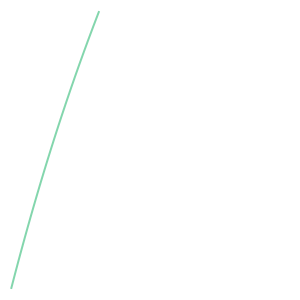

In [33]:
nadir_segment_ln

### Find alignment

In [34]:
az_nadir = calcAzimuth(line=nadir_segment_ln)

In [35]:
az_nadir

72.41249500094567

In [36]:
flowlines = flowlines.set_geometry('geometry')

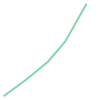

In [40]:
flowlines.iloc[0].geometry

In [37]:
flowlines['alignment'] = gdf_PIXC_clip.parallel_apply(user_defined_function=calcAzSin, axis=1)

/work/pi_cjgleason_umass_edu/.conda/envs/narrowPIXC/lib/python3.12/site-packages/scipy/stats/_stats_py.py:10730: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/work/pi_cjgleason_umass_edu/.conda/envs/narrowPIXC/lib/python3.12/site-packages/scipy/stats/_stats_py.py:10744: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/work/pi_cjgleason_umass_edu/.conda/envs/narrowPIXC/lib/python3.12/site-packages/scipy/stats/_stats_py.py:10750: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/work/pi_cjgleason_umass_edu/.conda/envs/narrowPIXC/lib/python3.12/site-packages/scipy/stats/_stats_py.py:10730: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/reaches.py:187: RuntimeWarning: invalid value encountered in scalar divide
  sinuosity = line.length/distance

ValueError: cannot reindex on an axis with duplicate labels

### Make pseudo pixels

In [34]:
# Set along-track pixel resolution
azimuth_res = 22 # meters

In [35]:
# Make pseudo pixels
start = time.time()
gdf_PIXC_clip['pseudo_pixel'] = gdf_PIXC_clip.parallel_apply(user_defined_function=makePseudoPixels,
                                                         args=(nadir_segment_ln,
                                                               azimuth_res),
                                                         axis=1)
end = time.time()
print(end - start)

1.348738431930542


In [ ]:
# fig, ax = plt.subplots(figsize=(8,8))
# gdf_PIXC_clip.iloc[5:10]['pseudo_pixel'].plot(ax=ax, alpha=0.5, color='y')
# gdf_PIXC_clip.iloc[5:10].plot(ax=ax, markersize=5, color='hotpink')

In [39]:
# xxxWHY NOT JUST KEEP THE SAME DATA FRAME AND DROP THE UNWANTED COLS?
# pseudo = gdf_PIXC_clip.drop(columns='geometry').set_geometry('pseudo_pixel').set_crs(crs=gdf_PIXC_clip.crs)
gdf_PIXC_clip = gdf_PIXC_clip.rename(columns={'geometry': 'pixel_centroid'}).set_geometry('pseudo_pixel').set_crs(epsg=3857)

In [41]:
# Get bounds of PIXC tile
pseudo_bounds = gdf_PIXC_clip.total_bounds
# Copy geometry column as sjoin will discard it
gdf_PIXC_clip['pseudo_geom'] = gdf_PIXC_clip.geometry
# pseudo_poly = box(pseudo_bounds[0], pseudo_bounds[1],
#                       pseudo_bounds[2], pseudo_bounds[3])
# gdf_pseudo_bounds = gpd.GeoDataFrame({'geometry': [pseudo_bounds]}, crs=pseudo.crs)

In [ ]:
# save_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/PIXC_v2_0_pseudo_pixels_filtered/'

In [ ]:
# gdf_PIXC.to_parquet(path=save_path + granule_name + '.parquet')

### Read in segments

In [42]:
# Create merged dataframe of all basins intersected
if len(indices) == 1:
    # Read prepped NHD
    segments, _, _ = readNHD(index=indices[0], segmented=True)
else:
    # Initialize lists
    d = []
    # Loop through indices and store in lists
    for i in indices:
        # Read prepped NHD
        segments, huc4, _ = readNHD(index=i, segmented=True)
        # Make column with HUC4 id
        segments['huc4_long'] = huc4
        segments['huc4'] = segments['huc4_long'].str[10:14]
        # Rename segments to geometry
        # segments = segments.rename(columns={'segments': 'geometry'}).set_geometry('geometry')
        # Append to list
        d.append(segments)
    # Merge GeoDataFrames
    segments = pd.concat(d)

type: segmented
NHDPLUS_H_0101_HU4_GDB
/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_segmented/HUC2_01/NHDPLUS_H_0101_HU4_GDB_prepped_segmented.parquet
segments read-in
type: segmented
NHDPLUS_H_0102_HU4_GDB
/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_segmented/HUC2_01/NHDPLUS_H_0102_HU4_GDB_prepped_segmented.parquet
segments read-in
type: segmented
NHDPLUS_H_0105_HU4_GDB
/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_segmented/HUC2_01/NHDPLUS_H_0105_HU4_GDB_prepped_segmented.parquet
segments read-in


In [ ]:
# # Cast objects to string type so they aren't dropped in groupby()
# segments['Bin'] = segments['Bin'].astype('|S')
# segments['GNIS_Name'] = segments['GNIS_Name'].astype(str).str.encode('utf-8', errors='replace').str.decode('utf-8')

In [ ]:
# segments['GNIS_Name'] = segments['GNIS_Name'].astype('|S')

In [43]:
# Project CRS (currently to WGS 84 / UTM zone 18N)
segments = segments.to_crs(epsg='3857')

In [44]:
segments = segments.reset_index().rename(columns={'index': 'index_old'})

In [45]:
# Assign a unique counter within each index group
segments['counter'] = segments.groupby('NHDPlusID').cumcount()

In [46]:
# Keep only first ten segments (some reaches repeat)
segments = segments[segments['counter'] < 10]

# For HUC4_0109, 5000700035256 and 5000700072690

In [47]:
segments = segments.clip(pseudo_bounds)

In [48]:
# Keep only reaches that are fully contained in PIXC granule
segments = segments.groupby('NHDPlusID').filter(lambda x: len(x) == 10)

In [49]:
len(segments['NHDPlusID'].unique())

976

In [50]:
len(segments.sort_values(by=['NHDPlusID', 'counter'])[::10]['NHDPlusID'].unique())

976

In [51]:
# Get number of reaches per bin
counts = pd.DataFrame(segments.sort_values(by=['NHDPlusID', 'counter'])[::10].Bin_Min.value_counts()).reset_index()

In [52]:
counts

,Bin_Min,count
0,"(0, 10]",835
1,"(10, 20]",67
2,"(40, 50]",37
3,"(20, 30]",29
4,"(30, 40]",8


In [53]:
# Buffer segments
## PARALLELIZE
start = time.time()
segments['buffer'] = segments.parallel_apply(user_defined_function=specialBuffer,
                                                         args=(width,
                                                               'flat', True, False),
                                                         axis=1)
end = time.time()
print(end - start)
# segments['buffered'] = segments.buffer(distance=(segments.WidthM/2), cap_style='flat')

0.7625961303710938


In [54]:
segments = segments.set_geometry('buffer').set_crs(epsg=3857)

In [55]:
# Calculate segment area
segments['segment_area'] = segments.geometry.area

In [ ]:
# segments.sort_values(['NHDPlusID', 'counter'])

In [ ]:
# segments_buff = segments.geometry.buffer(distance=(segments.WidthM/2), cap_style='flat')

In [ ]:
# segment_bounds = segments_buff.bounds

In [ ]:
# ## Clip the pseudo pixels to the bounds of the reach
# pseudo_all = pseudo.union_all()

In [ ]:
# fig, ax = plt.subplots(figsize=(8,8))
# pseudo.plot(ax=ax, column='klass')
# segments.plot(ax=ax, color='k', alpha=0.6)
# plt.xlim(824000, 826000)
# plt.ylim(4741000, 4743000)

In [ ]:
segments.crs

In [ ]:
gpd.sjoin(segments, gdf_PIXC_clip, predicate='intersects')

In [ ]:
# Merge the segments and pseudo-puxels by intersection
sj = gpd.sjoin(segments, gdf_PIXC_clip, how='left', predicate='intersects')

In [ ]:
sj.columns

In [ ]:
sj = sj.drop(columns=['index_right', 'points', 'azimuth_index',
                      'range_index',
                      # 'height', 'geoid',
                      # 'klass',
                      'latitude', 'longitude'])

In [ ]:
sj

In [ ]:
sj = sj.set_geometry('pseudo_geom')

In [ ]:
sj = sj.groupby('NHDPlusID', as_index=False).parallel_apply(user_defined_function=specialDissolve)

In [ ]:
sj = sj.reset_index().drop(columns=['level_0', 'level_1'])

In [ ]:
sj['pseudo_geom_clip'] = sj.parallel_apply(user_defined_function=specialClip,
                                                         axis=1)

In [ ]:
# sj[sj['NHDPlusID'] == 10000900090399].pseudo_geom.plot(cmap='hsv')

In [ ]:
# Calculate the pseudo-pixel area within each node
sj['pseudo_area'] = sj.pseudo_geom_clip.area

In [ ]:
sj['coverage'] = sj.pseudo_area/sj.segment_area

In [ ]:
# sj_w_zero = sj.copy()

In [ ]:
# sj_w_zero['coverage'] = sj_w_zero['coverage'].fillna(0)
sj['coverage'] = sj['coverage'].fillna(0)

### Do stats

In [ ]:
bins = sj.Bin.unique()

#### Reaches

In [ ]:
reaches_cent, reaches_thresh, reaches_min = summarizeCoverage(df=sj, binn=binn,
                                            bins=bins, counts=counts)

In [ ]:
reaches_min

In [ ]:
reaches_min.sort_values(by=['NHDPlusID'])[::10]

In [ ]:
# d = {}
# # d_q = {}
# for i in range(1, 10):
#     threshold = i/10
#     # print(threshold)
    
#     detected = sj.groupby([binn, 'NHDPlusID'])['coverage'].apply(lambda x: (x > threshold).sum()) / 10
#     reach = detected.reset_index()
    
#     # reach = detected.groupby(binn).quantile(q=[x / 100.0 for x in range(0,100,1)]).reset_index()
        
#     d[threshold] = reach

In [ ]:
# Add a column for each DataFrame indicating the key
# for threshold, data in d.items():
#     data['threshold'] = threshold
    
for threshold, data in d.items():
    data['threshold'] = threshold

In [ ]:
# Concatenate all DataFrames into one
# reaches_desc = pd.concat(d.values())

reaches_cent = pd.concat(d.values()).rename(columns={'level_1': 'centile'})

In [ ]:
reaches_cent

In [ ]:
# reaches_cent = pd.merge(left=reaches_cent, right=counts, how='left', on=binn)

In [ ]:
reaches_cent

In [ ]:
reaches_min = pd.DataFrame(sj.groupby('NHDPlusID')['coverage'].min()).reset_index()

In [ ]:
reaches_min = pd.merge(left=reaches_min, right=sj[['NHDPlusID', binn]], how='left', on='NHDPlusID')

In [ ]:
min_cov

In [ ]:
# reaches = pd.DataFrame(data=d).T

In [ ]:
# reaches.columns = bins

### Write out

In [ ]:
save_path = os.path.join('/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/', 'PIXC_v2_0_HUC2_01')

In [ ]:
# Combine node_desc
node_desc_both = pd.concat([node_desc, node_desc_w_zero], ignore_index=True)
node_desc_both

In [ ]:
# Combine node_quant
node_quant_both = pd.concat([node_quant, node_quant_w_zero], ignore_index=True)
node_quant_both

In [ ]:
# nodes_desc_both.to_csv(os.path.join(save_path, granule_name + '_nodes_describe.csv'))
# nodes_quant_both.to_csv(os.path.join(save_path, granule_name + '_nodes_quantile.csv'))

In [ ]:
# reaches_desc.to_csv(os.path.join(save_path, granule_name + '_reaches_describe.csv'))
# reaches_quant.to_csv(os.path.join(save_path, granule_name + '_reaches_quantile.csv'))

In [ ]:
test = pd.read_parquet('/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_output/PIXC_v2_0_HUC2_01_2025_03_02_min/SWOT_L2_HR_PIXC_004_242_074L_20230930T103957_20230930T104008_PGC0_01_reaches_thresh.parquet')

In [ ]:
test